In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix as sk_confusion_matrix

In [ ]:
def euclidean_distance(x1, x2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def normalize_features(X_train, X_test):
    """Z-score normalization of features"""
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1e-10  # Avoid division by zero

    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    return X_train_norm, X_test_norm

def evaluate(y_true, y_pred):
    """Calculate accuracy score"""
    return np.sum(y_true == y_pred) / len(y_true)

def enhanced_map_clusters_to_speakers(cluster_labels, true_labels):
    """Advanced mapping from clusters to speaker labels"""
    unique_clusters = np.unique(cluster_labels)
    unique_speakers = np.unique(true_labels)

    # Calculate confusion matrix between clusters and speakers
    confusion = np.zeros((len(unique_clusters), len(unique_speakers)))
    for i, cluster in enumerate(unique_clusters):
        for j, speaker in enumerate(unique_speakers):
            confusion[i, j] = np.sum((cluster_labels == cluster) & (true_labels == speaker))

    purity = np.zeros(len(unique_clusters))
    mapping = {}

    # First pass: assign high-confidence mappings
    assigned_speakers = set()
    for i, cluster in enumerate(unique_clusters):
        cluster_sum = np.sum(confusion[i])
        if cluster_sum > 0:
            purity[i] = np.max(confusion[i]) / cluster_sum
            if purity[i] >= 0.7:
                speaker_idx = np.argmax(confusion[i])
                speaker = unique_speakers[speaker_idx]
                mapping[cluster] = speaker
                assigned_speakers.add(speaker)

    # Second pass: assign remaining clusters
    for i, cluster in enumerate(unique_clusters):
        if cluster not in mapping:
            cluster_sum = np.sum(confusion[i])
            if cluster_sum > 0:
                # Get top speaker candidates
                top_indices = np.argsort(-confusion[i])[:3]

                # Try to assign to unassigned speakers first
                assigned = False
                for idx in top_indices:
                    speaker = unique_speakers[idx]
                    if speaker not in assigned_speakers and confusion[i, idx] > 0:
                        mapping[cluster] = speaker
                        assigned_speakers.add(speaker)
                        assigned = True
                        break

                if not assigned:
                    speaker_idx = np.argmax(confusion[i])
                    mapping[cluster] = unique_speakers[speaker_idx]
            else:
                mapping[cluster] = unique_speakers[0]

    # Map prediction labels
    mapped_labels = np.array([mapping[label] for label in cluster_labels])
    print(f"Average cluster purity: {np.mean(purity):.4f}")

    return mapped_labels

In [ ]:
def calculate_inertia(X, labels, centroids):
    """Calculate inertia (sum of squared distances to centroids)"""
    inertia = 0
    for i, point in enumerate(X):
        inertia += euclidean_distance(point, centroids[labels[i]]) ** 2
    return inertia

def calculate_cluster_purity(cluster_labels, true_labels):
    """Calculate purity for each cluster"""
    unique_clusters = np.unique(cluster_labels)
    unique_speakers = np.unique(true_labels)

    # Calculate confusion matrix
    confusion = np.zeros((len(unique_clusters), len(unique_speakers)))
    for i, cluster in enumerate(unique_clusters):
        for j, speaker in enumerate(unique_speakers):
            confusion[i, j] = np.sum((cluster_labels == cluster) & (true_labels == speaker))

    # Calculate purity for each cluster
    cluster_purities = {}
    cluster_sizes = {}

    for i, cluster in enumerate(unique_clusters):
        cluster_sum = np.sum(confusion[i])
        if cluster_sum > 0:
            purity = np.max(confusion[i]) / cluster_sum
            cluster_purities[cluster] = purity
            cluster_sizes[cluster] = cluster_sum

    return cluster_purities, cluster_sizes, confusion

Plotting Functions

In [ ]:
def plot_inertia_vs_k(k_values, inertia_values, optimal_k):
    """Plot Inertia vs K (Elbow Method)"""
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia_values, 'o-', linewidth=2, markersize=8)
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.xlabel('Number of Clusters (K)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.title('Elbow Method for Optimal K', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_cluster_purity(cluster_purities, cluster_sizes, optimal_k):
    """Plot cluster purity as a bar chart"""
    # Sort clusters by size (descending)
    sorted_clusters = sorted(cluster_purities.keys(), key=lambda k: cluster_sizes[k], reverse=True)
    purities = [cluster_purities[k] for k in sorted_clusters]
    sizes = [cluster_sizes[k] for k in sorted_clusters]

    # Limit to top 20 clusters if there are many
    if len(sorted_clusters) > 20:
        sorted_clusters = sorted_clusters[:20]
        purities = purities[:20]
        sizes = sizes[:20]

    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(sorted_clusters)), purities, color='skyblue')

    # Color bars by purity
    for i, purity in enumerate(purities):
        if purity >= 0.9:
            bars[i].set_color('darkgreen')
        elif purity >= 0.7:
            bars[i].set_color('yellowgreen')
        elif purity >= 0.5:
            bars[i].set_color('orange')
        else:
            bars[i].set_color('salmon')

    # Add size annotations
    for i, (purity, size) in enumerate(zip(purities, sizes)):
        plt.annotate(f'{size}', xy=(i, purity+0.02), ha='center', fontsize=9)

    plt.xlabel('Cluster Index (sorted by size)', fontsize=12)
    plt.ylabel('Purity', fontsize=12)
    plt.title(f'Cluster Purity for K={optimal_k}', fontsize=14)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_speaker_distribution(confusion_matrix, unique_clusters, unique_speakers, optimal_k):
    """Plot speaker distribution across clusters as stacked bar plot"""
    # Select top clusters by size
    cluster_sizes = np.sum(confusion_matrix, axis=1)
    top_indices = np.argsort(-cluster_sizes)[:min(15, len(unique_clusters))]

    # Get top speakers in each cluster
    speakers_per_cluster = {}
    for i in top_indices:
        cluster = unique_clusters[i]
        # Get top 5 speakers in this cluster
        top_speaker_indices = np.argsort(-confusion_matrix[i])[:5]
        speakers = [(unique_speakers[j], confusion_matrix[i][j]) for j in top_speaker_indices
                  if confusion_matrix[i][j] > 0]
        speakers_per_cluster[cluster] = speakers

    # Create stacked bar chart
    plt.figure(figsize=(14, 8))

    # Prepare data for stacking
    bottoms = np.zeros(len(speakers_per_cluster))
    cluster_indices = list(range(len(speakers_per_cluster)))
    cluster_labels = list(speakers_per_cluster.keys())

    # Use a colormap
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    speaker_color_map = {}

    # Plot each speaker's contribution to each cluster
    legend_handles = []
    legend_labels = []

    for speaker_idx in range(5):  # Max 5 speakers per cluster
        heights = []
        for cluster in speakers_per_cluster:
            speakers = speakers_per_cluster[cluster]
            if speaker_idx < len(speakers):
                speaker, count = speakers[speaker_idx]
                heights.append(count)

                # Assign color to speaker
                if speaker not in speaker_color_map:
                    speaker_color_map[speaker] = colors[len(speaker_color_map) % len(colors)]
            else:
                heights.append(0)

        # Plot this speaker's contribution across all clusters
        unique_speakers_in_this_row = set()
        for i, h in enumerate(heights):
            if h > 0:
                speakers = speakers_per_cluster[cluster_labels[i]]
                speaker = speakers[speaker_idx][0]
                if speaker not in unique_speakers_in_this_row:
                    unique_speakers_in_this_row.add(speaker)
                    bar = plt.bar(cluster_indices[i], h, bottom=bottoms[i],
                                 color=speaker_color_map[speaker], label=f'Speaker {speaker}')
                    if speaker not in legend_labels:
                        legend_handles.append(bar)
                        legend_labels.append(f'Speaker {speaker}')
                else:
                    plt.bar(cluster_indices[i], h, bottom=bottoms[i],
                          color=speaker_color_map[speaker])

        # Update bottoms for next stack
        bottoms = [bottoms[i] + heights[i] for i in range(len(heights))]

    plt.xlabel('Cluster Index', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title(f'Speaker Distribution in Top Clusters (K={optimal_k})', fontsize=14)
    plt.xticks(cluster_indices, [f'C{c}' for c in cluster_labels], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

Optimal K Search

In [ ]:
def find_optimal_k(kmeans_model, X_train, X_val, y_val, k_range):
    """Find optimal K using validation accuracy and track inertia for elbow method"""
    val_accuracies = []
    inertia_values = []

    for k in k_range:
        print(f"Testing K = {k}")
        # Train on training data
        labels, centroids = kmeans_model.fit(X_train, k)

        # Calculate inertia
        inertia = calculate_inertia(X_train, labels, centroids)
        inertia_values.append(inertia)
        print(f"Inertia: {inertia:.2f}")

        # Evaluate on validation
        val_labels = kmeans_model.predict(X_val, centroids)
        mapped_val_labels = enhanced_map_clusters_to_speakers(val_labels, y_val)
        val_acc = evaluate(y_val, mapped_val_labels)
        val_accuracies.append(val_acc)

        print(f"Validation Accuracy: {val_acc:.4f}")

    # Get optimal K
    optimal_k_idx = np.argmax(val_accuracies)
    optimal_k = k_range[optimal_k_idx]

    # Plot validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, val_accuracies, 'o-', color='green')
    plt.axvline(x=optimal_k, color='r', linestyle='--')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy vs K (Best: {val_accuracies[optimal_k_idx]:.4f} at K={optimal_k})')
    plt.grid(True)
    plt.show()

    # Plot inertia vs K (Elbow Method)
    plot_inertia_vs_k(k_range, inertia_values, optimal_k)

    print(f"Selected K: {optimal_k} (validation accuracy: {val_accuracies[optimal_k_idx]:.4f})")

    return optimal_k, val_accuracies[optimal_k_idx], inertia_values

KMeans Class Definition

In [ ]:
# KMeans Clustering Implementation

class KMeans:
    """K-Means clustering implementation for speaker recognition"""

    def __init__(self):
        self.centroids = None

    def _kmeans_plus_plus_init(self, X, k):
        """K-means++ initialization with better starting centroids"""
        centroids = [X[np.random.randint(0, len(X))]]

        for _ in range(1, k):
            dist_sq = np.array([min([euclidean_distance(x, c)**2 for c in centroids]) for x in X])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.random()
            ind = np.searchsorted(cumulative_probs, r)
            centroids.append(X[ind])

        return np.array(centroids)

    def fit(self, X, k, max_iters=200, n_init=20):
        """Fit KMeans model and return cluster assignments and centroids"""
        best_inertia = float('inf')
        best_labels = None
        best_centroids = None

        for _ in range(n_init):
            # K-means++ initialization
            centroids = self._kmeans_plus_plus_init(X, k)

            # Run K-means algorithm
            labels = np.zeros(len(X), dtype=int)
            for iteration in range(max_iters):
                prev_labels = labels.copy()
                for i, point in enumerate(X):
                    distances = [euclidean_distance(point, centroid) for centroid in centroids]
                    labels[i] = np.argmin(distances)

                if np.array_equal(prev_labels, labels):
                    break

                # Update centroids
                for j in range(k):
                    points_in_cluster = X[labels == j]
                    if len(points_in_cluster) > 0:
                        centroids[j] = points_in_cluster.mean(axis=0)

            #calculate Inertia
            inertia = 0
            for i, point in enumerate(X):
                inertia += euclidean_distance(point, centroids[labels[i]]) ** 2

            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = centroids.copy()

        self.centroids = best_centroids
        return best_labels, best_centroids

    def predict(self, X, centroids=None):
        """Predict cluster assignments for data points"""
        if centroids is None:
            if self.centroids is None:
                raise ValueError("Model not fitted yet, call fit first or provide centroids")
            centroids = self.centroids

        labels = np.zeros(len(X), dtype=int)
        for i, point in enumerate(X):
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            labels[i] = np.argmin(distances)
        return labels


Main Function

In [ ]:
def main():
    """Main function to run speaker recognition in the notebook"""
    # Load data
    print("Loading data...")
    X_lda = np.load('X_lda.npy')
    y_labels = np.load('y_labels.npy')

    # Split data into train/val/test sets
    print("Splitting data into train/val/test sets...")
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_lda, y_labels, test_size=0.3, random_state=43
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=43
    )
    print(f"Dataset splits: train={X_train.shape[0]}, val={X_val.shape[0]}, test={X_test.shape[0]}")

    # Normalize features
    print("Normalizing features...")
    X_train_norm, X_test_norm = normalize_features(X_train, X_test)
    _, X_val_norm = normalize_features(X_train, X_val)

    # Get number of unique speakers
    n_speakers = len(np.unique(y_train))
    print(f"Number of unique speakers: {n_speakers}")

    # Initialize K-means model
    kmeans_model = KMeans()

    # Find optimal K using validation set
    print("Finding optimal K...")
    k_range = range(45, 51)
    optimal_k, val_accuracy, inertia_values = find_optimal_k(kmeans_model, X_train_norm, X_val_norm, y_val, k_range)
    print(f"Optimal K = {optimal_k}")

    # Train with optimal K
    print("Training with optimal K...")
    train_labels, centroids = kmeans_model.fit(X_train_norm, optimal_k, n_init=25, max_iters=300)

    # Calculate training accuracy
    mapped_train_labels = enhanced_map_clusters_to_speakers(train_labels, y_train)
    train_accuracy = evaluate(y_train, mapped_train_labels)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Generate cluster purity visualization
    print("Generating cluster purity visualization...")
    cluster_purities, cluster_sizes, confusion = calculate_cluster_purity(train_labels, y_train)
    plot_cluster_purity(cluster_purities, cluster_sizes, optimal_k)

    # Generate speaker distribution visualization
    print("Generating speaker distribution visualization...")
    unique_clusters = np.unique(train_labels)
    unique_speakers = np.unique(y_train)
    plot_speaker_distribution(confusion, unique_clusters, unique_speakers, optimal_k)

    # Predict test labels and evaluate
    test_labels = kmeans_model.predict(X_test_norm)
    mapped_test_labels = enhanced_map_clusters_to_speakers(test_labels, y_test)
    test_accuracy = evaluate(y_test, mapped_test_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Plot confusion matrix
    cm = sk_confusion_matrix(y_test, mapped_test_labels)
    plt.figure(figsize=(25, 25), dpi=300)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Speaker Recognition (Accuracy: {test_accuracy:.4f})')
    plt.show()

    print("\nFinal Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return kmeans_model, mapped_test_labels


Loading data...
Splitting data into train/val/test sets...
Dataset splits: train=1405, val=352, test=754
Normalizing features...
Number of unique speakers: 50
Finding optimal K...
Testing K = 45
Inertia: 30938.77
Average cluster purity: 0.9031
Validation Accuracy: 0.8665
Testing K = 46
Inertia: 30732.84
Average cluster purity: 0.9165
Validation Accuracy: 0.8949
Testing K = 47
Inertia: 30328.66
Average cluster purity: 0.9033
Validation Accuracy: 0.8693
Testing K = 48
Inertia: 29326.78
Average cluster purity: 0.9053
Validation Accuracy: 0.8807
Testing K = 49
Inertia: 29198.57
Average cluster purity: 0.9492
Validation Accuracy: 0.9148
Testing K = 50
Inertia: 29597.12
Average cluster purity: 0.8897
Validation Accuracy: 0.8722


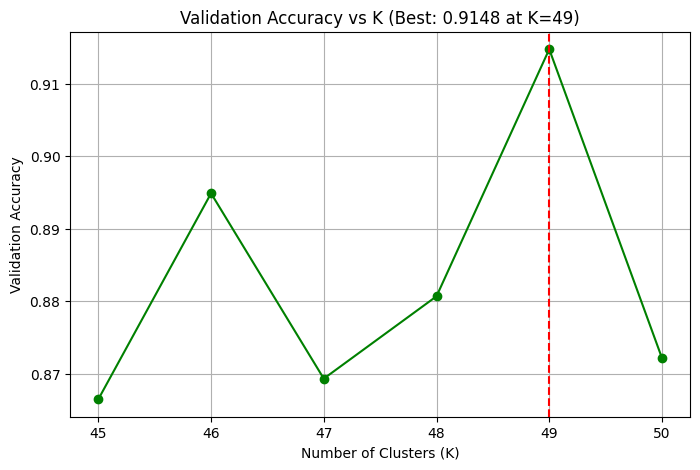

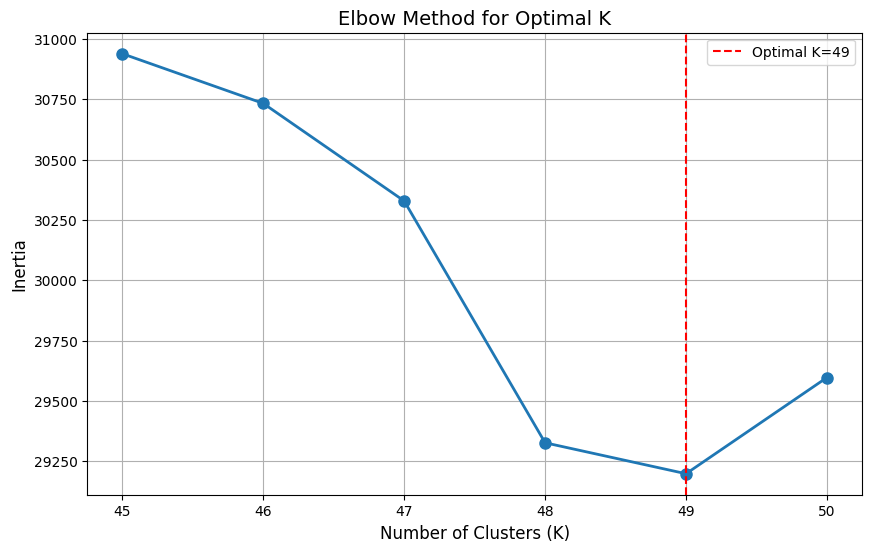

Selected K: 49 (validation accuracy: 0.9148)
Optimal K = 49
Training with optimal K...
Average cluster purity: 0.9264
Training Accuracy: 0.9374
Generating cluster purity visualization...


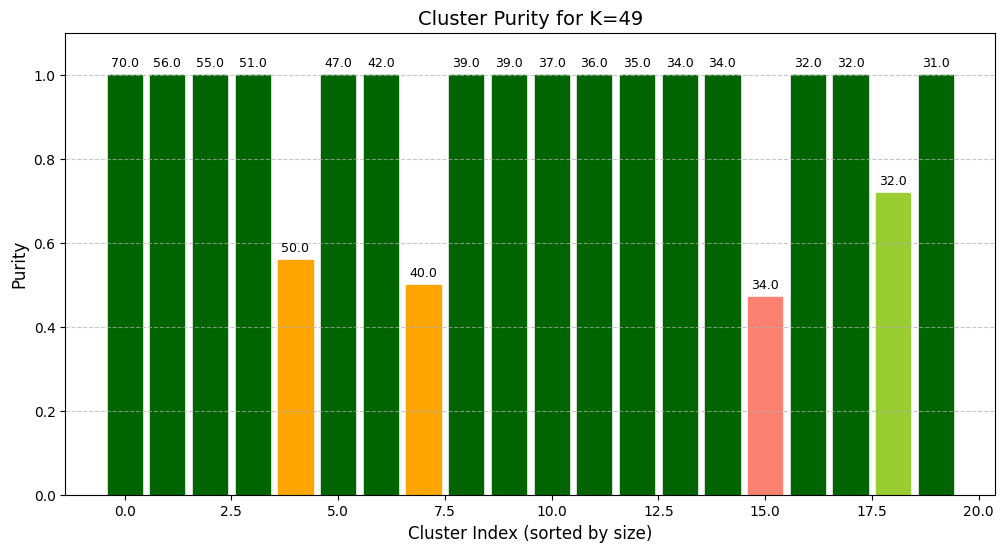

Generating speaker distribution visualization...


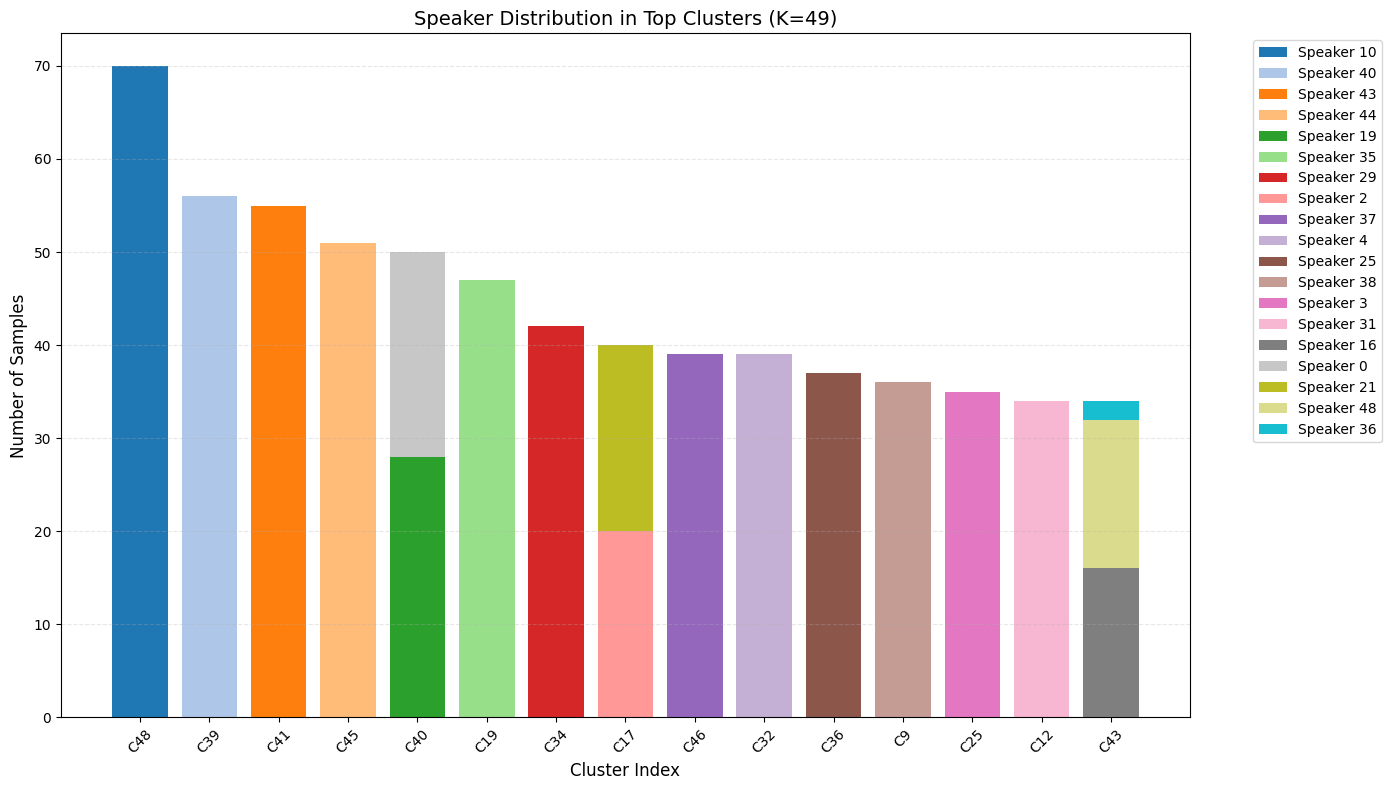

Average cluster purity: 0.9595
Test Accuracy: 0.9403


<Figure size 7500x7500 with 0 Axes>

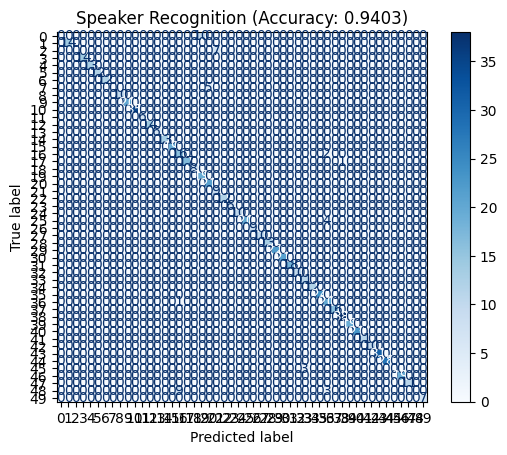


Final Results:
Training Accuracy: 0.9374
Validation Accuracy: 0.9148
Test Accuracy: 0.9403


In [ ]:
# Run the main function to execute the speaker recognition workflow
if __name__ == "__main__":
    main()